# CNN
- 합성곱 계층: 사진의 뉴런이 늘어남 (Convolution)
- 풀링 계층: 사이즈를 줄임 (Pooling)
- Feature Extraction & Classification

In [1]:
import cv2
img = cv2.imread('./images/digits.png', 0)
print(img.shape)

(1000, 2000)


In [2]:
import numpy as np
import pandas as pd

cells = [np.hsplit(row, 100) for row in np.vsplit(img, 50)]
x = np.array(cells)/255.
img_rows, img_cols = 20, 20
X = x.reshape(-1, img_rows, img_cols, 1)
y = pd.get_dummies(np.repeat(np.arange(10), 500)).to_numpy()

from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

print(train_X.shape, train_y.shape)

(3500, 20, 20, 1) (3500, 10)


In [3]:
from tensorflow.keras.models import Sequential

model = Sequential()

In [4]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Dropout, MaxPooling2D

model.add(Conv2D(32, kernel_size=(3,3), input_shape=(img_rows, img_cols, 1), activation='relu')) #28, 28, 1
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [5]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['acc'])

In [6]:
hist = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=200, batch_size=128, verbose=1)

Epoch 1/200
28/28 [==============================] - 2s 52ms/step - loss: 2.2066 - acc: 0.2227 - val_loss: 1.4389 - val_acc: 0.6707
Epoch 2/200
28/28 [==============================] - 1s 22ms/step - loss: 1.3646 - acc: 0.5671 - val_loss: 0.5775 - val_acc: 0.8447
Epoch 3/200
28/28 [==============================] - 1s 22ms/step - loss: 0.7354 - acc: 0.7764 - val_loss: 0.3838 - val_acc: 0.8893
Epoch 4/200
28/28 [==============================] - 1s 22ms/step - loss: 0.5375 - acc: 0.8379 - val_loss: 0.3097 - val_acc: 0.9020
Epoch 5/200
28/28 [==============================] - 1s 23ms/step - loss: 0.4200 - acc: 0.8712 - val_loss: 0.2386 - val_acc: 0.9220
Epoch 6/200
28/28 [==============================] - 1s 22ms/step - loss: 0.3492 - acc: 0.8934 - val_loss: 0.2186 - val_acc: 0.9260
Epoch 7/200
28/28 [==============================] - 1s 24ms/step - loss: 0.3040 - acc: 0.9057 - val_loss: 0.1979 - val_acc: 0.9340
Epoch 8/200
28/28 [==============================] - 1s 22ms/step - loss: 0.

28/28 [==============================] - 1s 22ms/step - loss: 0.0225 - acc: 0.9948 - val_loss: 0.1050 - val_acc: 0.9740
Epoch 63/200
28/28 [==============================] - 1s 21ms/step - loss: 0.0225 - acc: 0.9940 - val_loss: 0.1037 - val_acc: 0.9733
Epoch 64/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0236 - acc: 0.9908 - val_loss: 0.0947 - val_acc: 0.9740
Epoch 65/200
28/28 [==============================] - 1s 21ms/step - loss: 0.0361 - acc: 0.9869 - val_loss: 0.0965 - val_acc: 0.9740
Epoch 66/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0255 - acc: 0.9916 - val_loss: 0.1002 - val_acc: 0.9767
Epoch 67/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0325 - acc: 0.9885 - val_loss: 0.0917 - val_acc: 0.9740
Epoch 68/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0347 - acc: 0.9889 - val_loss: 0.0950 - val_acc: 0.9747
Epoch 69/200
28/28 [==============================] - 1s 21ms/step - loss: 0.0262 

28/28 [==============================] - 1s 22ms/step - loss: 0.0120 - acc: 0.9951 - val_loss: 0.1133 - val_acc: 0.9767
Epoch 124/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0098 - acc: 0.9973 - val_loss: 0.1117 - val_acc: 0.9753
Epoch 125/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0107 - acc: 0.9973 - val_loss: 0.1194 - val_acc: 0.9753
Epoch 126/200
28/28 [==============================] - 1s 21ms/step - loss: 0.0076 - acc: 0.9985 - val_loss: 0.1251 - val_acc: 0.9760
Epoch 127/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0176 - acc: 0.9945 - val_loss: 0.1114 - val_acc: 0.9767
Epoch 128/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0105 - acc: 0.9968 - val_loss: 0.1235 - val_acc: 0.9760
Epoch 129/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0160 - acc: 0.9957 - val_loss: 0.1162 - val_acc: 0.9793
Epoch 130/200
28/28 [==============================] - 1s 22ms/step - loss: 

28/28 [==============================] - 1s 22ms/step - loss: 0.0079 - acc: 0.9981 - val_loss: 0.1239 - val_acc: 0.9767
Epoch 185/200
28/28 [==============================] - 1s 21ms/step - loss: 0.0060 - acc: 0.9981 - val_loss: 0.1208 - val_acc: 0.9773
Epoch 186/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0056 - acc: 0.9980 - val_loss: 0.1233 - val_acc: 0.9753
Epoch 187/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0083 - acc: 0.9967 - val_loss: 0.1222 - val_acc: 0.9780
Epoch 188/200
28/28 [==============================] - 1s 23ms/step - loss: 0.0048 - acc: 0.9988 - val_loss: 0.1339 - val_acc: 0.9767
Epoch 189/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0159 - acc: 0.9952 - val_loss: 0.1195 - val_acc: 0.9767
Epoch 190/200
28/28 [==============================] - 1s 22ms/step - loss: 0.0092 - acc: 0.9967 - val_loss: 0.1256 - val_acc: 0.9773
Epoch 191/200
28/28 [==============================] - 1s 22ms/step - loss: 

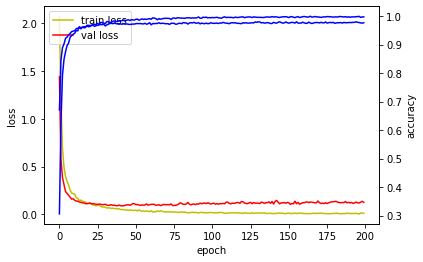

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'b', label ='train acc')
acc_ax.plot(hist.history['val_acc'], 'b', label ='val acc')
acc_ax.set_ylabel('accuracy')
# acc_ax.set_legend(loc='lower left')

plt.show()

AttributeError: 'History' object has no attribute 'accuracy'

In [ ]:
import cv2
import numpy as np
cap = cv2.VideoCapture(0)

if cap.isOpened():
    while True:
        ret, img = cap.read()
        if ret:
            g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, bin_img = cv2.threshold(g_img, 110, 255, cv2.THRESH_BINARY_INV)
            contours, hierarchy = cv2.findContours(bin_img, 
                        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # CHAIN_APPROX_SIMPLE 테두리를 잡아줌 
            try:
                for i in range(len(contours)):
                    contour = contours[i]
                    (x,y), radius = cv2.minEnclosingCircle(contour)
                    if radius > 3:
                        xs, xe = int(x-radius), int(x+radius)
                        ys, ye = int(y-radius), int(y+radius)
                        cv2.rectangle(bin_img, (xs, ys), (xe, ye), (200, 0, 0), 1)
                        roi = bin_img[ys:ye, xs:xe]
                        dst = cv2.resize(roi, dsize = (50, 50))
                        dst = cv2.resize(dst, dsize = (24, 24)) #16, 16
                        A = np.zeros((28,28))  # 20, 20
                        A[2:-2, 2:-2] = dst[:,:]
                        A = A.reshape(-1,28, 28, 1)  #-1, 20, 20, 1
                        num =np.argmax(model.predict(A))
                        cv2.putText(bin_img, str(num), (xs,ys), cv2.FONT_HERSHEY_PLAIN, 2, (200, 0, 0))
            except Exception as e:
                print(e)
            cv2.imshow("Image", bin_img)
            if cv2.waitKey(1) & 0xFF ==27:
                break
        else:
            print("Np Frame")
            break
else:
    print("Camera not opened")

cap.release()
cv2.destroyAllWindows()

### Mnist

In [ ]:
from tensorflow.keras.datasets import mnist
(train_img, train_labels), (test_img, test_labels) = mnist.load_data()

In [ ]:
#X의 모양을 입력 모양에 맞도록 수정

train_img = train_img.reshape(-1, 28, 28, 1)
test_img = test_img.reshape(-1, 28, 28, 1)

#표준화
train_img = train_img.astype('float32')/255
test_img = test_img.astype('float32') / 255

#y를 원-핫 인코딩 

from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
model.fit(train_img, train_labels, validation_data=(test_img, test_labels), epochs=20, batch_size=128, verbose=1)